In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

# Loading the dataset


In [8]:
df = pd.read_csv("/content/spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
df = df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df = df.rename(columns={'v1': 'target', 'v2': 'text'})
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df = df.replace({'ham': 0, 'spam': 1})
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


# Data Cleaning

In [13]:
df.isnull().sum()

,0
target,0
text,0


In [14]:
df.duplicated().sum()

np.int64(403)

In [15]:
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

np.int64(0)

In [16]:
df = df.reset_index(drop=True)
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
df.shape

(5169, 2)

In [18]:
df.value_counts('target')

,count
target,
0,4516
1,653


# Data Preprocessing

In [21]:

def preprocess(text):
  if text is not None:

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
  else:
    text = ''
  return text

In [22]:
df['text'] = df['text'].apply(preprocess)
df.head()

,target,text
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


# Exploratory Data Analysis


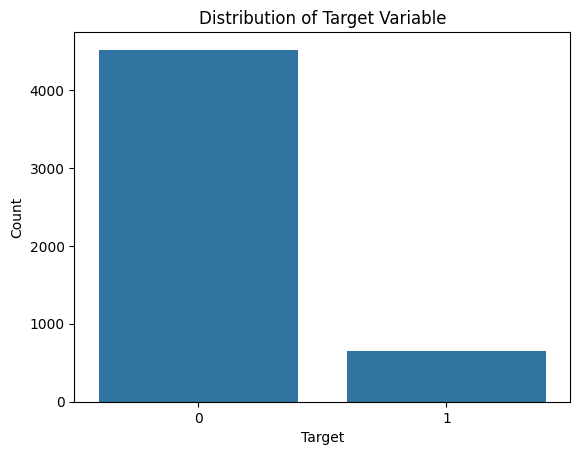

In [23]:
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [24]:
df['text_length'] = df['text'].apply(len)
df.head()

,target,text,text_length
0,0,go until jurong point crazy available only in ...,102
1,0,ok lar joking wif u oni,23
2,1,free entry in 2 a wkly comp to win fa cup fina...,149
3,0,u dun say so early hor u c already then say,43
4,0,nah i dont think he goes to usf he lives aroun...,59


# Splitting the data

In [25]:
x = df['text']
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [26]:

vector = TfidfVectorizer(ngram_range=(1, 2))
x_train_tfidf = vector.fit_transform(x_train)
x_test_tfidf = vector.transform(x_test)

In [27]:
print(x_test_tfidf[0].toarray().shape)

(1, 42722)


In [28]:

doc_index = 0
feature_names = vector.get_feature_names_out()
doc_tfidf = x_train_tfidf[doc_index].toarray().flatten()

top_indices = np.argsort(doc_tfidf)[::-1][:10]

for idx in top_indices:
    print(f"{feature_names[idx]}: {doc_tfidf[idx]:.4f}")


wined: 0.2732
wined and: 0.2732
dined: 0.2732
dined before: 0.2732
cool so: 0.2732
been wined: 0.2732
and dined: 0.2732
come you: 0.2604
havent been: 0.2513
you havent: 0.2442


In [29]:
models = {
    "SVC" : SVC(),
    "BernoulliNB" : BernoulliNB(),
    "LogisticRegression" : LogisticRegression()
}

# Training the Models

In [30]:
for model_name, model in models.items():
  model.fit(x_train_tfidf, y_train)
  y_pred = model.predict(x_test_tfidf)

  accuracy = accuracy_score(y_test, y_pred)

  print("Model Name : ", model_name)
  print()

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))
  print()

  print(f"Model Accuracy: {accuracy*100:.2f}")

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))
  print()

Model Name :  SVC

Confusion Matrix:
[[902   1]
 [ 26 105]]

Model Accuracy: 97.39

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       903
           1       0.99      0.80      0.89       131

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.94      1034
weighted avg       0.97      0.97      0.97      1034


Model Name :  BernoulliNB

Confusion Matrix:
[[903   0]
 [ 81  50]]

Model Accuracy: 92.17

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       903
           1       1.00      0.38      0.55       131

    accuracy                           0.92      1034
   macro avg       0.96      0.69      0.75      1034
weighted avg       0.93      0.92      0.91      1034


Model Name :  LogisticRegression

Confusion Matrix:
[[902   1]
 [ 45  86]]

Model Accuracy: 95.55

Classification Report:


In [31]:
best_accuracy = 0
best_model_name = ""

for model_name, model in models.items():
  y_pred = model.predict(x_test_tfidf)
  accuracy = accuracy_score(y_test, y_pred)

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model_name = model_name

print("Best Model : ", best_model_name)
print(f"Best Model Accuracy: {best_accuracy*100:.2f}")

Best Model :  SVC
Best Model Accuracy: 97.39
